In [1]:
# Artificial Neural Network - MNIST Classification
# Practice Lab Notebook with comments & from-scratch implementations

# ==============================
# PHẦN 1: IMPORT THƯ VIỆN CẦN THIẾT
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import pandas as pd

* tensorflow: Thư viện nền tảng.
* keras: API cấp cao bên trong TensorFlow.
* layers: Module chứa các loại lớp mạng (Dense, Conv2D, LSTM...).
* numpy: Xử lý mảng dữ liệu hiệu quả.
* matplotlib: Trực quan hóa dữ liệu (ví dụ: xem một vài ảnh MNIST).


(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

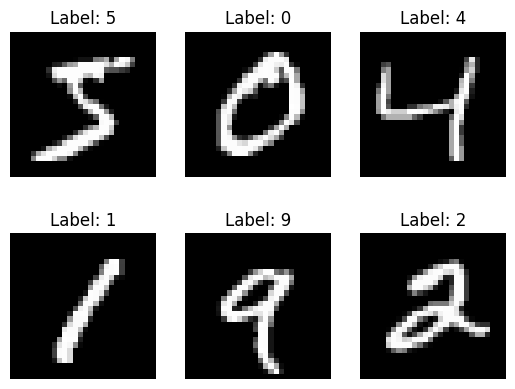

In [2]:
# ==============================
# PHẦN 2: LOAD VÀ TIỀN XỬ LÝ DỮ LIỆU
# ==============================
## Tải bộ dữ liệu MNIST (đã được chia sẵn thành tập huấn luyện và tập kiểm tra)
data =  mnist.load_data()

(x_train, y_train), (x_test, y_test) = data
print(data[0])
# Xem kích thước dữ liệu
print("Kích thước dữ liệu huấn luyện (ảnh):", x_train.shape) # Output: (60000, 28, 28) -> 60k ảnh, mỗi ảnh 28x28 pixel
print("Kích thước dữ liệu huấn luyện (nhãn):", y_train.shape) # Output: (60000,) -> 60k nhãn (số từ 0-9)
print("Kích thước dữ liệu kiểm tra (ảnh):", x_test.shape)   # Output: (10000, 28, 28)
print("Kích thước dữ liệu kiểm tra (nhãn):", y_test.shape)   # Output: (10000,)
# Hiển thị vài ảnh mẫu
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


In [3]:
# 1. Chuẩn hóa giá trị pixel về khoảng [0, 1]
# Giá trị pixel gốc từ 0 đến 255. Chuẩn hóa giúp mô hình hội tụ nhanh và ổn định hơn.

x_train = x_train / 255.0
x_test = x_test / 255.0


# 3. Chuyển đổi nhãn thành dạng One-Hot Encoding
# Ví dụ: nhãn số 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] (vector 10 chiều)
# Cần thiết khi sử dụng hàm mất mát 'categorical_crossentropy'
# VD: y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Nhãn gốc của mẫu đầu tiên:", y_train[0])
# Output: (60000, 10)


# Reshape lại input cho phù hợp
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

Nhãn gốc của mẫu đầu tiên: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [4]:

# ==============================
# PHẦN 3: VIẾT HÀM MÔ PHỎNG MẠNG NEURAL TỪ ĐẦU
# ==============================
# Hàm kích hoạt sigmoid và đạo hàm của nó
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Softmax activation cho output layer
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Hàm mất mát categorical crossentropy
def cross_entropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

In [5]:
# ==============================
# PHẦN 4: KHOI TẠO MÔ HÌNH MẠNG NEURAL ĐƠN GIẢN
# ==============================
# 1 hidden layer: input (784) -> hidden (64) -> output (10)
input_size = 784
hidden_size = 64
output_size = 10

# Khởi tạo trọng số và bias
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))


In [6]:

# ==============================
# PHẦN 5: TRAINING - FORWARD VÀ BACKPROPAGATION
# ==============================
learning_rate = 0.1
epochs = 10
batch_size = 128

for epoch in range(epochs):
    permutation = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[permutation]
    y_train_shuffled = y_train[permutation]

    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        # Forward
        z1 = np.dot(x_batch, W1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, W2) + b2
        a2 = softmax(z2)

        # Loss
        loss = cross_entropy(y_batch, a2)

        # Backward
        dz2 = a2 - y_batch
        dW2 = np.dot(a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = np.dot(dz2, W2.T) * sigmoid_derivative(z1)
        dW1 = np.dot(x_batch.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Update weights
        W2 -= learning_rate * dW2 / batch_size
        b2 -= learning_rate * db2 / batch_size
        W1 -= learning_rate * dW1 / batch_size
        b1 -= learning_rate * db1 / batch_size

        


In [7]:
# ==============================
# PHẦN 6: ĐÁNH GIÁ MÔ HÌNH
# ==============================
def predict(x):
    a1 = sigmoid(np.dot(x, W1) + b1)
    a2 = softmax(np.dot(a1, W2) + b2)
    return np.argmax(a2, axis=1)

predictions = predict(x_test)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_true)
print("Test accuracy:", accuracy)


Test accuracy: 0.9294


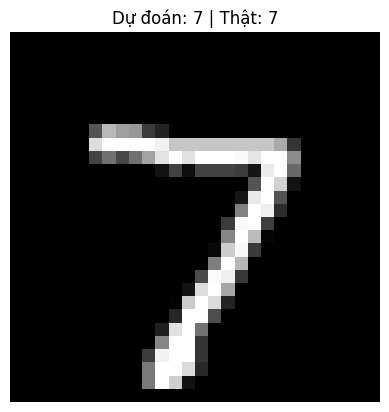

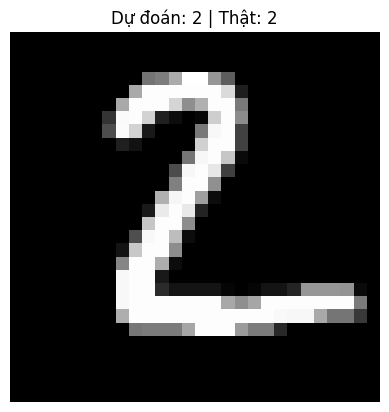

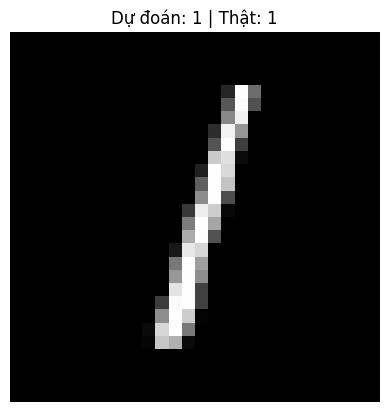

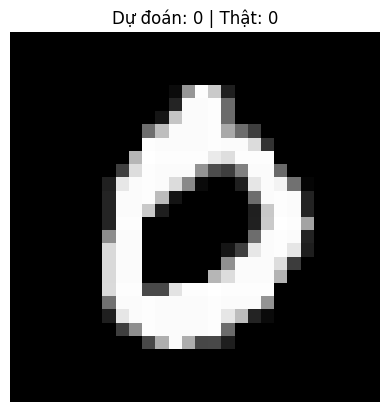

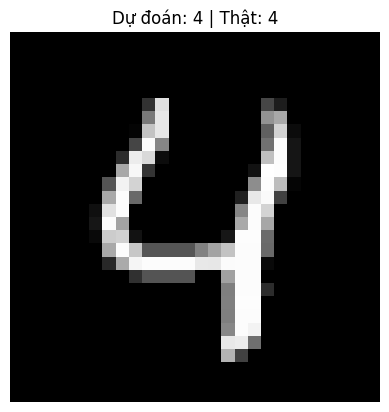

In [8]:
# ==============================
# PHẦN 7: HIỂN THỊ VÍ DỤ DỰ ĐOÁN
# ==============================
for i in range(5):
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Dự đoán: {predictions[i]} | Thật: {y_true[i]}")
    plt.axis('off')
    plt.show()
